In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.6.0
device: cpu


This is the MNIST dataset with labels 3 and 4.
Imbalanced Ratio:  0.1
Number of label 3 in the final training set:  6131
Number of label 4 in the final training set (after downsampling):  613
Number of label 3 in the final test set:  1010
Number of label 4 in the final test set:  982
Total samples in final training set:  6744
Total samples in final test set:  1992
Number of batches in training set:  106
Number of batches in test set:  32
Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
First image tensor:
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

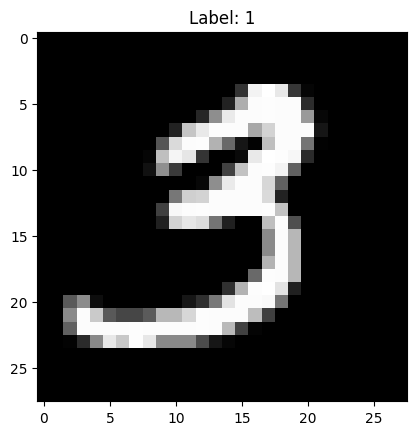

X_train.shape: (6744, 784)
y_train.shape: (6744,)
X_test.shape: (1992, 784)
y_test.shape: (1992,)


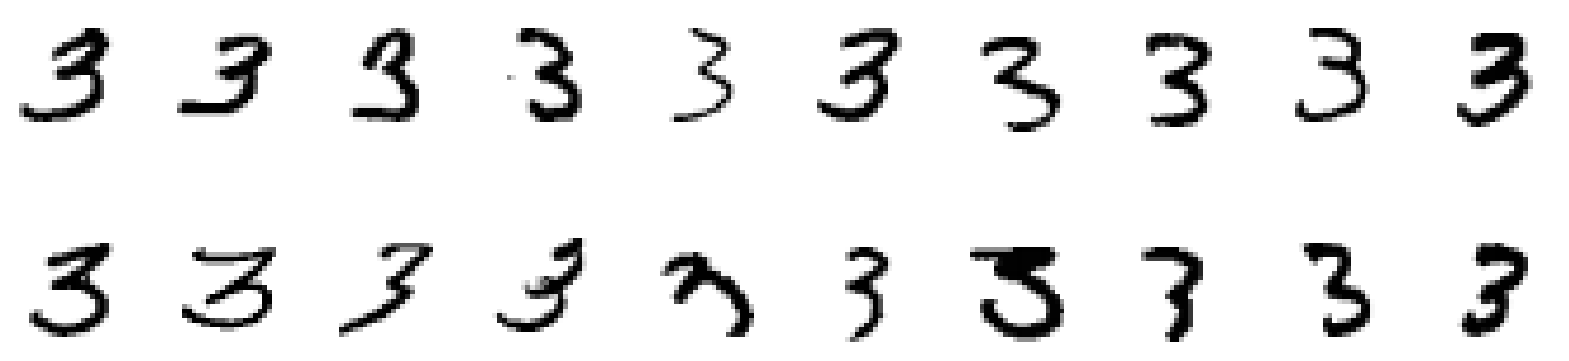

In [3]:
# Data
from Get_datasets import get_datasets
X_train, y_train, X_test, y_test, train_loader, test_loader = get_datasets(dataname="mnist34",fraction=0.1)
# Hyperparameters
img_size = 28 # Image size
batch_size = 64  # Batch size
# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]
# Training
epochs = 100  # Train epochs
learning_rate = 1e-4

In [4]:
print(train_loader)
print(test_loader)

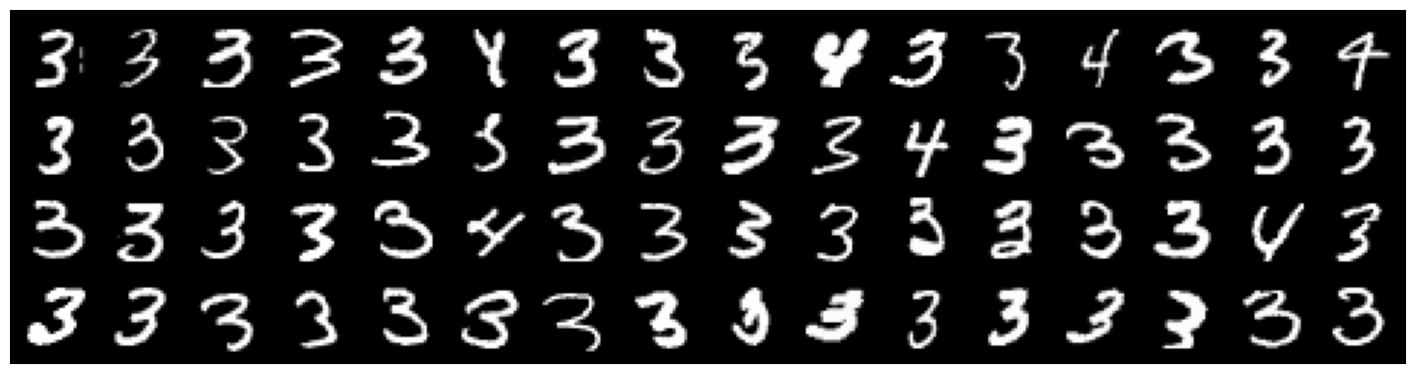

In [5]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

In [6]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [8]:
class_num = 2
class_list = [ '3', '4']
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

In [9]:
# Loss function
criterion = nn.BCELoss()

In [10]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [11]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [12]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

In [13]:
for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (images, labels) in enumerate(train_loader):
        
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # Set generator train
        generator.train()
        
        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    # Building z 
    z = Variable(torch.randn(class_num-1, z_size)).to(device)
    
    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
    
    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    
    # Show images
    print(sample_images.shape)
    #grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    #plt.imshow(grid)
    #plt.show()

Starting epoch 1...
g_loss: 1.0964884757995605, d_loss: 0.6354454755783081
torch.Size([1, 1, 28, 28])
Starting epoch 2...
g_loss: 1.2226003408432007, d_loss: 1.0415356159210205
torch.Size([1, 1, 28, 28])
Starting epoch 3...
g_loss: 0.7745413780212402, d_loss: 1.4237616062164307
torch.Size([1, 1, 28, 28])
Starting epoch 4...
g_loss: 1.4838688373565674, d_loss: 0.8506149053573608
torch.Size([1, 1, 28, 28])
Starting epoch 5...
g_loss: 0.36702507734298706, d_loss: 1.6723244190216064
torch.Size([1, 1, 28, 28])
Starting epoch 6...
g_loss: 0.7537534236907959, d_loss: 1.1791300773620605
torch.Size([1, 1, 28, 28])
Starting epoch 7...
g_loss: 2.393733263015747, d_loss: 0.4251496195793152
torch.Size([1, 1, 28, 28])
Starting epoch 8...
g_loss: 4.9216508865356445, d_loss: 0.9161679744720459
torch.Size([1, 1, 28, 28])
Starting epoch 9...
g_loss: 1.656187891960144, d_loss: 0.7058329582214355
torch.Size([1, 1, 28, 28])
Starting epoch 10...
g_loss: 4.080945014953613, d_loss: 1.0935704708099365
torch.Si

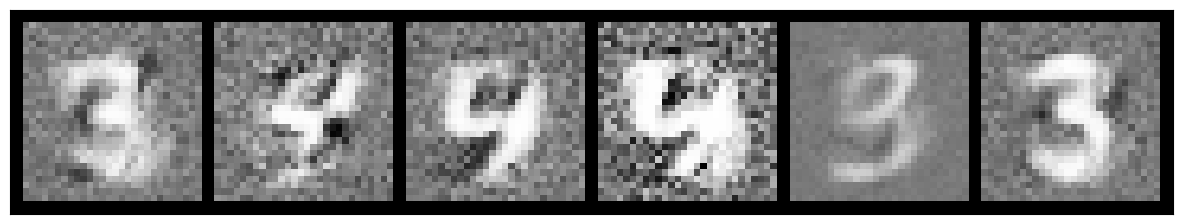

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

z_size = 100  # Adjust based on your model
class_num = 2  # Adjust based on dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 只生成 Class 0 的样本
num_samples = 6 # 生成多少个样本
z = torch.randn(num_samples, z_size).to(device)  # Shape: (num_samples, z_size)
#labels = torch.zeros(num_samples, dtype=torch.long).to(device)  # 全部设为 0 类
labels = torch.tensor([1, 0, 0, 0, 1, 1], dtype=torch.long).to(device)  # 转换为 PyTorch 张量
# Generate images using the generator
sample_images = generator(z, labels).unsqueeze(1).data.cpu()  # Ensure correct batch dimension

# Make image grid
grid = make_grid(sample_images, nrow=num_samples, normalize=True).permute(1, 2, 0).numpy()

# Plot images
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(grid)
ax.set_xticks([])
ax.set_yticks([])
plt.show()